In [1]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

sys.path.append("..")
from utils.util_functions import *

# MLB

In [2]:
event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")

In [3]:
"""df = event_df[event_df.攻撃チーム==team]
team = "Rソックス"
columns = list(df.columns)
case_index = columns.index("状況")
try:
    inning_index = columns.index("イニング")
except:
    inning_index = columns.index("回")
top_index = columns.index("表得点")
bot_index = columns.index("裏得点")

inning_list = []
for inning in range(18):
    curr_inning_list = []
    for i in range(len(df)):
        if df.iloc[i, case_index] == "GAMESET":
            continue
        if int(df.iloc[i, inning_index].split("回")[0]) == inning + 1:
            try:
                curr_inning_list.append((df.iloc[i, case_index], abs(int(df.iloc[i, top_index])-int(df.iloc[i, bot_index]))))
            except:
                curr_inning_list.append((df.iloc[i, case_index], np.nan))
    inning_list.append(curr_inning_list)"""

'df = event_df[event_df.攻撃チーム==team]\nteam = "Rソックス"\ncolumns = list(df.columns)\ncase_index = columns.index("状況")\ntry:\n    inning_index = columns.index("イニング")\nexcept:\n    inning_index = columns.index("回")\ntop_index = columns.index("表得点")\nbot_index = columns.index("裏得点")\n\ninning_list = []\nfor inning in range(18):\n    curr_inning_list = []\n    for i in range(len(df)):\n        if df.iloc[i, case_index] == "GAMESET":\n            continue\n        if int(df.iloc[i, inning_index].split("回")[0]) == inning + 1:\n            try:\n                curr_inning_list.append((df.iloc[i, case_index], abs(int(df.iloc[i, top_index])-int(df.iloc[i, bot_index]))))\n            except:\n                curr_inning_list.append((df.iloc[i, case_index], np.nan))\n    inning_list.append(curr_inning_list)'

In [4]:
#pd.DataFrame(inning_list[6]).describe()

In [5]:
"""team = "Rソックス"
df = event_df[event_df.攻撃チーム==team]
triple = make_inning_triple(make_inning_list(df, score_end=4))
lst = make_flattened_list(triple)"""

'team = "Rソックス"\ndf = event_df[event_df.攻撃チーム==team]\ntriple = make_inning_triple(make_inning_list(df, score_end=4))\nlst = make_flattened_list(triple)'

In [6]:
"""df = pd.DataFrame(lst)
score_diff = df[1].apply(lambda x: x[1])
df = df.applymap(lambda x: x[0])
df["点差"] = score_diff
df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]"""

'df = pd.DataFrame(lst)\nscore_diff = df[1].apply(lambda x: x[1])\ndf = df.applymap(lambda x: x[0])\ndf["点差"] = score_diff\ndf_with_score = df[(df[0]!="3000") & (df[1]!="3000")]'

In [7]:
#len(df_with_score[df_with_score.点差<=1][[0, 1, 2]].values.tolist())

# 回点差指定せず、流れのいい時だけ

In [8]:
diffs = []
stds = []
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = [elem for elem in df_with_score[df_with_score.点差<=30][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1], "score")]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team).describe()[column]["std"] / make_score_df_mlb(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)

マーリンズ -0.041230547323190425 0.745161351662
ブルージェイズ -0.036784109599770076 0.666022782951
Wソックス -0.03674307977747793 0.720786613389
ロイヤルズ -0.0350448624935531 0.757228903468
ジャイアンツ -0.03598208876267517 0.737955073316
ブレーブス -0.044134725435501565 0.70938418131
メッツ -0.03360213174755655 0.735159694044
マリナーズ -0.03910944048112208 0.668948069586
カブス -0.039760454651401655 0.763224672511
カージナルス -0.0415462283474235 0.668960338682
レンジャーズ -0.04321345030554147 0.714067340083
アスレチックス -0.033282302158589516 0.640292515595
ロッキーズ -0.036632949732192444 0.6973869369
フィリーズ -0.03751199993134913 0.72758841746
ブリュワーズ -0.038397075043556494 0.670083659328
ヤンキース -0.03306578620004785 0.61072599013
レッズ -0.04073374247909234 0.678095136226
レイズ -0.034668107392084035 0.70014369491
パイレーツ -0.03728042827036404 0.713864249192
ドジャース -0.03951415327721319 0.697131500955
オリオールズ -0.03915509462854061 0.781906801829
ツインズ -0.034040256303539795 0.649470212774
Dバックス -0.04090914209296548 0.708102395369
インディアンス -0.039783888314137705 0.7

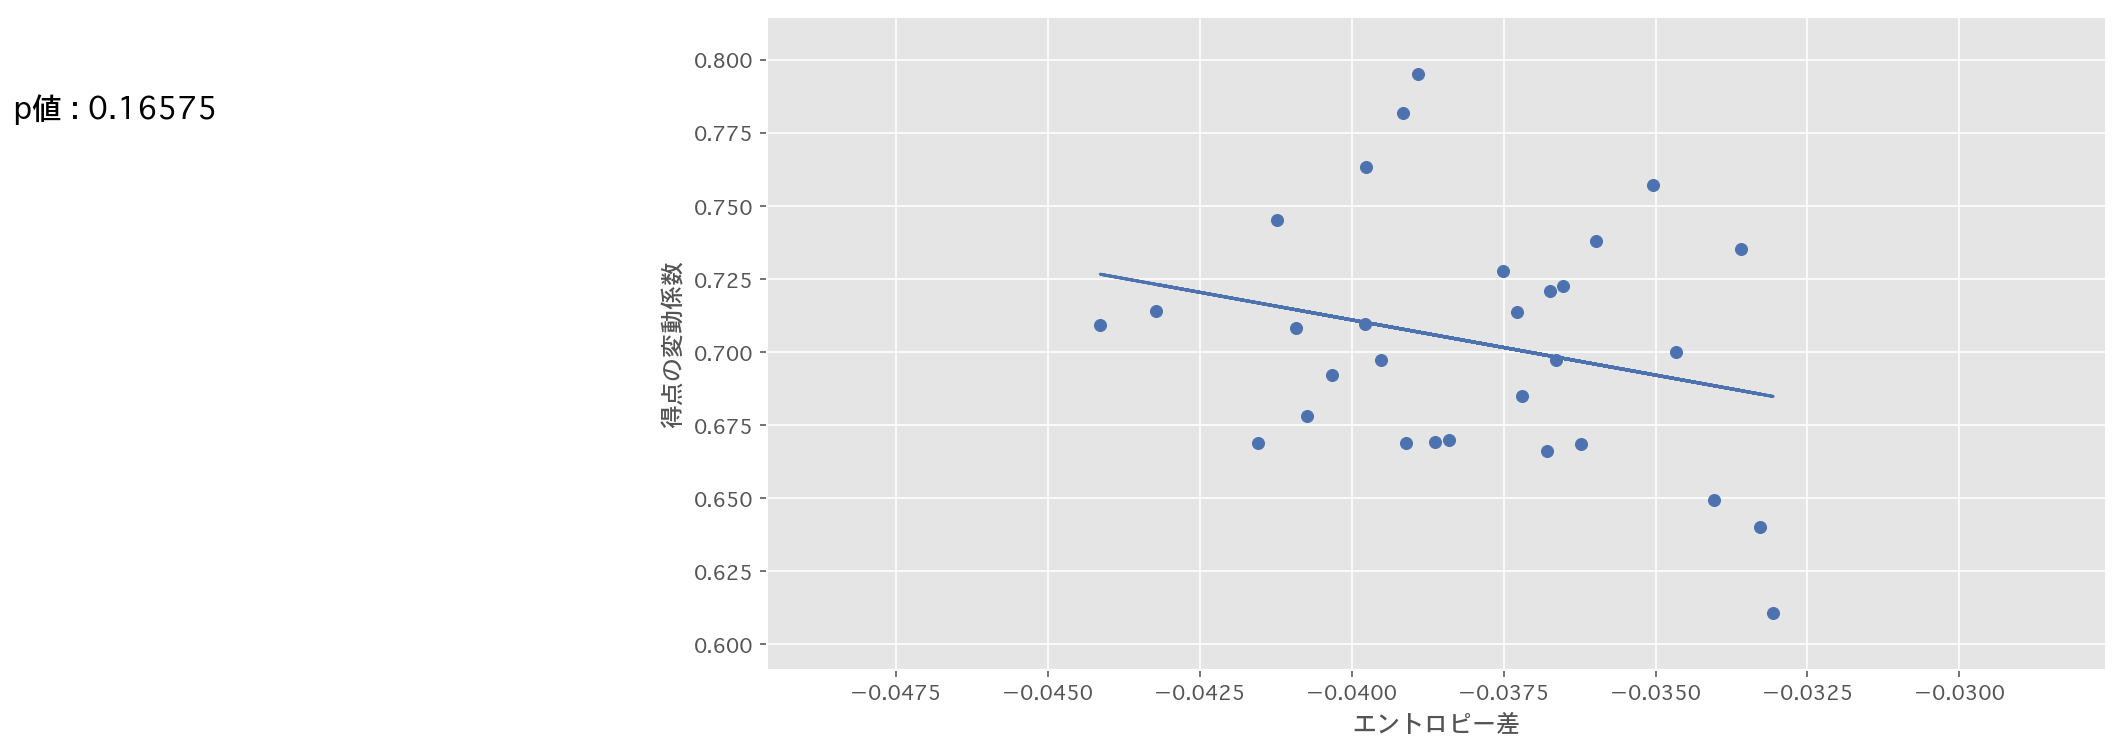

In [9]:
import statsmodels.api as sm

plt.figure(figsize=(12, 6))

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.xlabel("エントロピー差")
plt.ylabel("得点の変動係数")
plt.text(x=-0.062, y=0.78, s="p値 : "+str(results.pvalues[1])[:7], fontsize=15)
plt.show()

# 5回以降だけ考えて点差気にせず・流れのいい時だけ

In [10]:
diffs = []
stds = []
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[4:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = [elem for elem in df_with_score[df_with_score.点差<=30][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1], "score")]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team).describe()[column]["std"] / make_score_df_mlb(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)

マーリンズ -0.05756256913416502 0.745161351662
ブルージェイズ -0.057910780820831675 0.666022782951
Wソックス -0.054171039871190096 0.720786613389
ロイヤルズ -0.053231064892798496 0.757228903468
ジャイアンツ -0.048863873171503425 0.737955073316
ブレーブス -0.061854283521120657 0.70938418131
メッツ -0.04894280076095692 0.735159694044
マリナーズ -0.056698969108978314 0.668948069586
カブス -0.057332394914911156 0.763224672511
カージナルス -0.0575498568696422 0.668960338682
レンジャーズ -0.0621846873227927 0.714067340083
アスレチックス -0.04698384096122288 0.640292515595
ロッキーズ -0.05360112546632001 0.6973869369
フィリーズ -0.05315802436021366 0.72758841746
ブリュワーズ -0.053205919938899005 0.670083659328
ヤンキース -0.05006445646900337 0.61072599013
レッズ -0.05494647166264688 0.678095136226
レイズ -0.04661685324694931 0.70014369491
パイレーツ -0.05627979589055698 0.713864249192
ドジャース -0.05744409633274827 0.697131500955
オリオールズ -0.04874464662199518 0.781906801829
ツインズ -0.05063346187392348 0.649470212774
Dバックス -0.06336309811499596 0.708102395369
インディアンス -0.055821495374684726 0.70

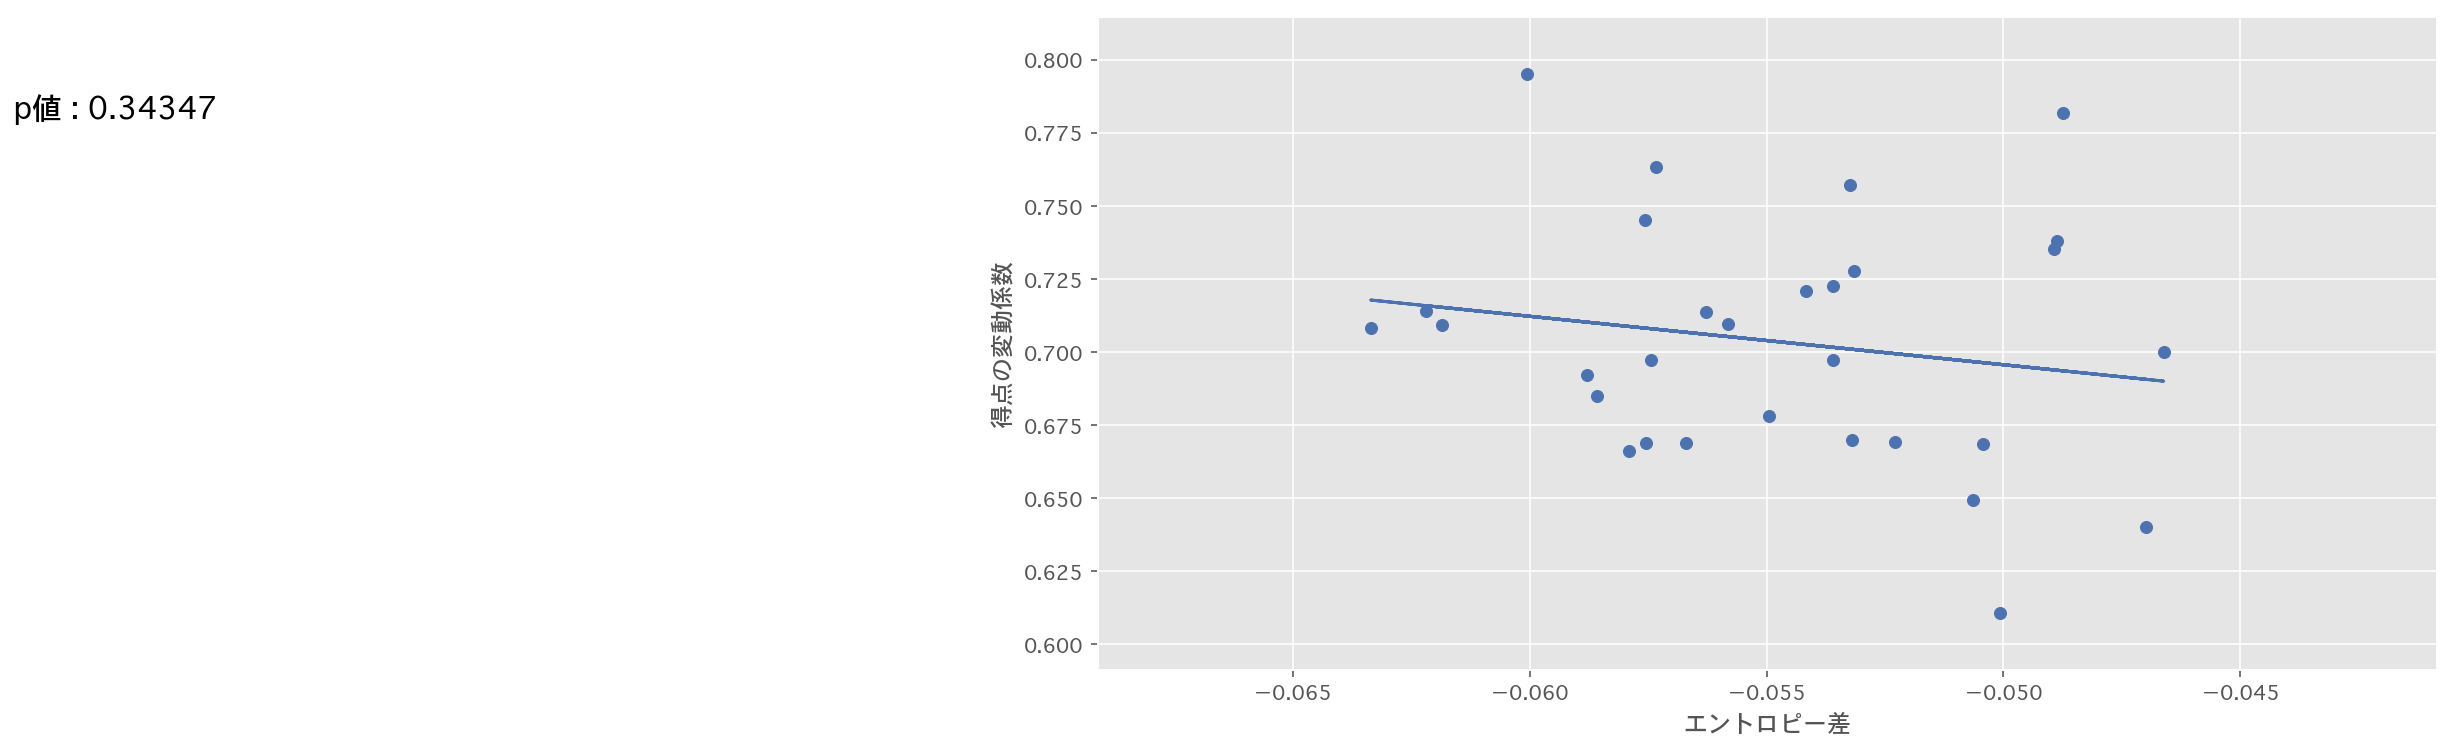

In [11]:
import statsmodels.api as sm

plt.figure(figsize=(12, 6))

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.xlabel("エントロピー差")
plt.ylabel("得点の変動係数")
plt.text(x=-0.092, y=0.78, s="p値 : "+str(results.pvalues[1])[:7], fontsize=15)
plt.show()

# 回を気にせず4点差いない・流れがいい時

In [12]:
diffs = []
stds = []
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = [elem for elem in df_with_score[df_with_score.点差<=4][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1], "score")]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team).describe()[column]["std"] / make_score_df_mlb(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)

マーリンズ -0.04383704299250413 0.745161351662
ブルージェイズ -0.03764032274364926 0.666022782951
Wソックス -0.04130093081482711 0.720786613389
ロイヤルズ -0.03955170802517349 0.757228903468
ジャイアンツ -0.0401217381004102 0.737955073316
ブレーブス -0.04553745915450813 0.70938418131
メッツ -0.039121265130453775 0.735159694044
マリナーズ -0.04203992073427276 0.668948069586
カブス -0.042428046820642606 0.763224672511
カージナルス -0.04602977760978222 0.668960338682
レンジャーズ -0.04856428721344086 0.714067340083
アスレチックス -0.03743808256742609 0.640292515595
ロッキーズ -0.04073233986014824 0.6973869369
フィリーズ -0.03926004533207639 0.72758841746
ブリュワーズ -0.04059575629039891 0.670083659328
ヤンキース -0.03763540372841456 0.61072599013
レッズ -0.04648285908734673 0.678095136226
レイズ -0.03830870725374025 0.70014369491
パイレーツ -0.042371661701275265 0.713864249192
ドジャース -0.04242194886665729 0.697131500955
オリオールズ -0.04525377318754531 0.781906801829
ツインズ -0.03676606725887144 0.649470212774
Dバックス -0.04424906529159145 0.708102395369
インディアンス -0.0439547020633535 0.70947933

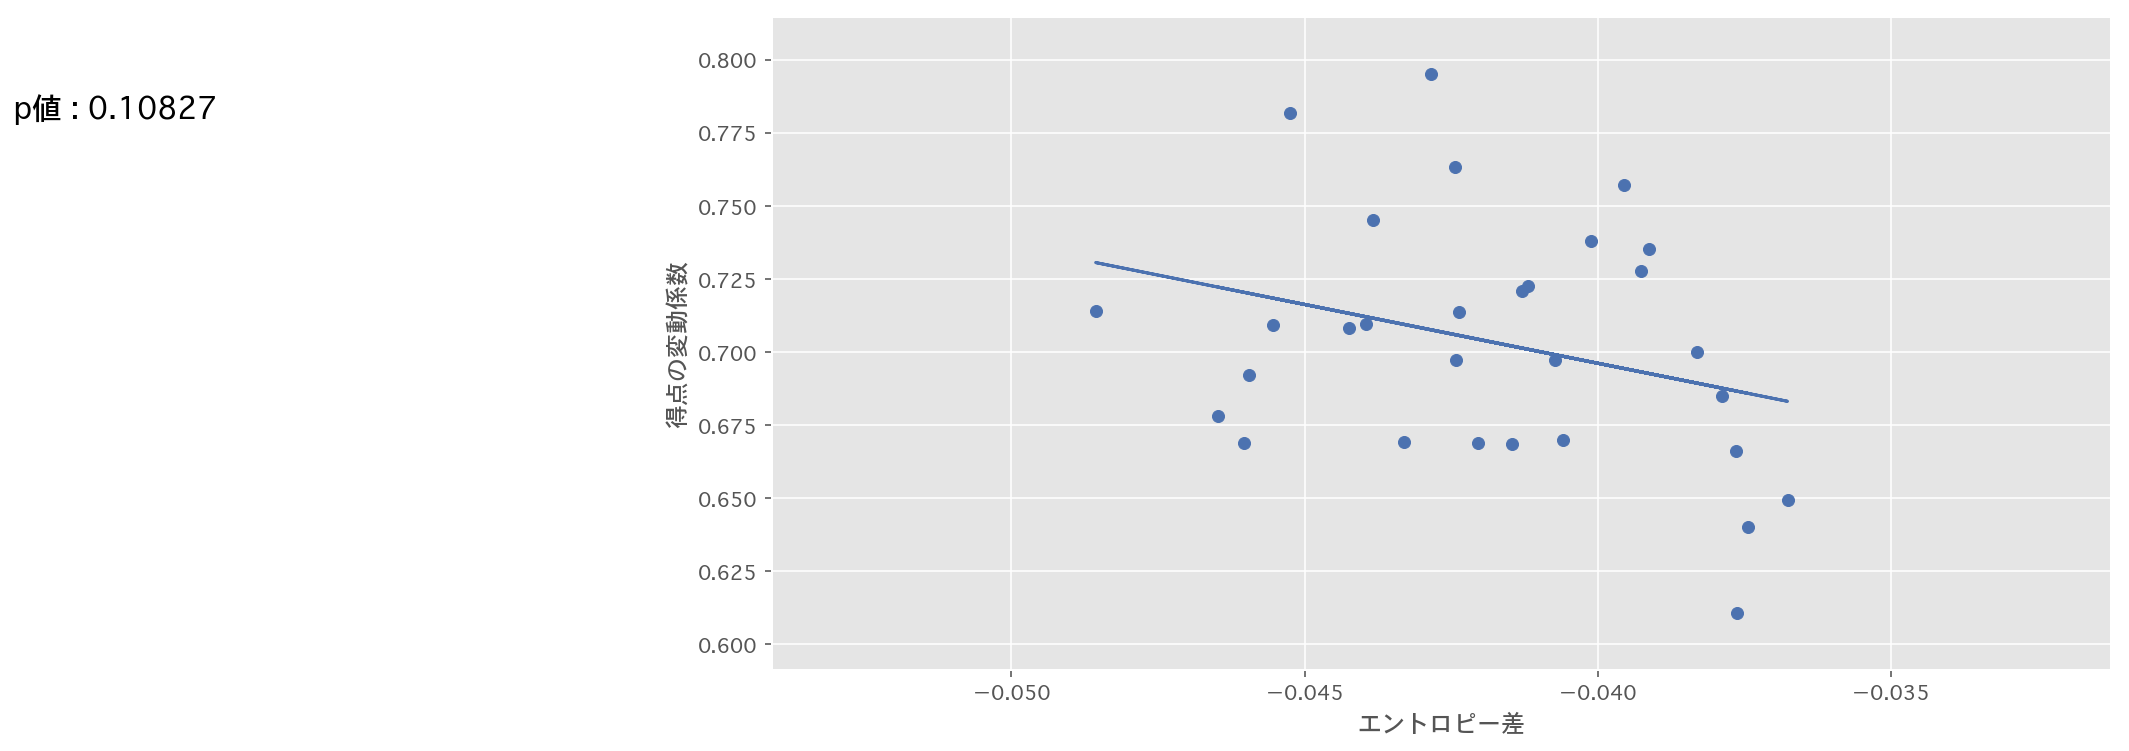

In [13]:
import statsmodels.api as sm

plt.figure(figsize=(12, 6))

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.xlabel("エントロピー差")
plt.ylabel("得点の変動係数")
plt.text(x=-0.067, y=0.78, s="p値 : "+str(results.pvalues[1])[:7], fontsize=15)
plt.show()

# 5回以降の4点差いないの状況で、流れがいい時

In [14]:
diffs = []
stds = []
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[4:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = [elem for elem in df_with_score[df_with_score.点差<=4][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1], "score")]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team).describe()[column]["std"] / make_score_df_mlb(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)

マーリンズ -0.067561888190387 0.745161351662
ブルージェイズ -0.0641378752689783 0.666022782951
Wソックス -0.06654027758163572 0.720786613389
ロイヤルズ -0.06488872179977179 0.757228903468
ジャイアンツ -0.059683310369224696 0.737955073316
ブレーブス -0.06685043453660455 0.70938418131
メッツ -0.05973123505867628 0.735159694044
マリナーズ -0.06270331795334538 0.668948069586
カブス -0.061289499870680775 0.763224672511
カージナルス -0.06720044189379237 0.668960338682
レンジャーズ -0.07422790413489588 0.714067340083
アスレチックス -0.05314711965028618 0.640292515595
ロッキーズ -0.06098596459986538 0.6973869369
フィリーズ -0.06207742177466047 0.72758841746
ブリュワーズ -0.055162784295230693 0.670083659328
ヤンキース -0.05683741452544799 0.61072599013
レッズ -0.06334033289036745 0.678095136226
レイズ -0.05457279073274579 0.70014369491
パイレーツ -0.06408833709637962 0.713864249192
ドジャース -0.06451052804451907 0.697131500955
オリオールズ -0.06427409055187239 0.781906801829
ツインズ -0.05819004946414763 0.649470212774
Dバックス -0.07277881674629239 0.708102395369
インディアンス -0.05743950254750585 0.709479335

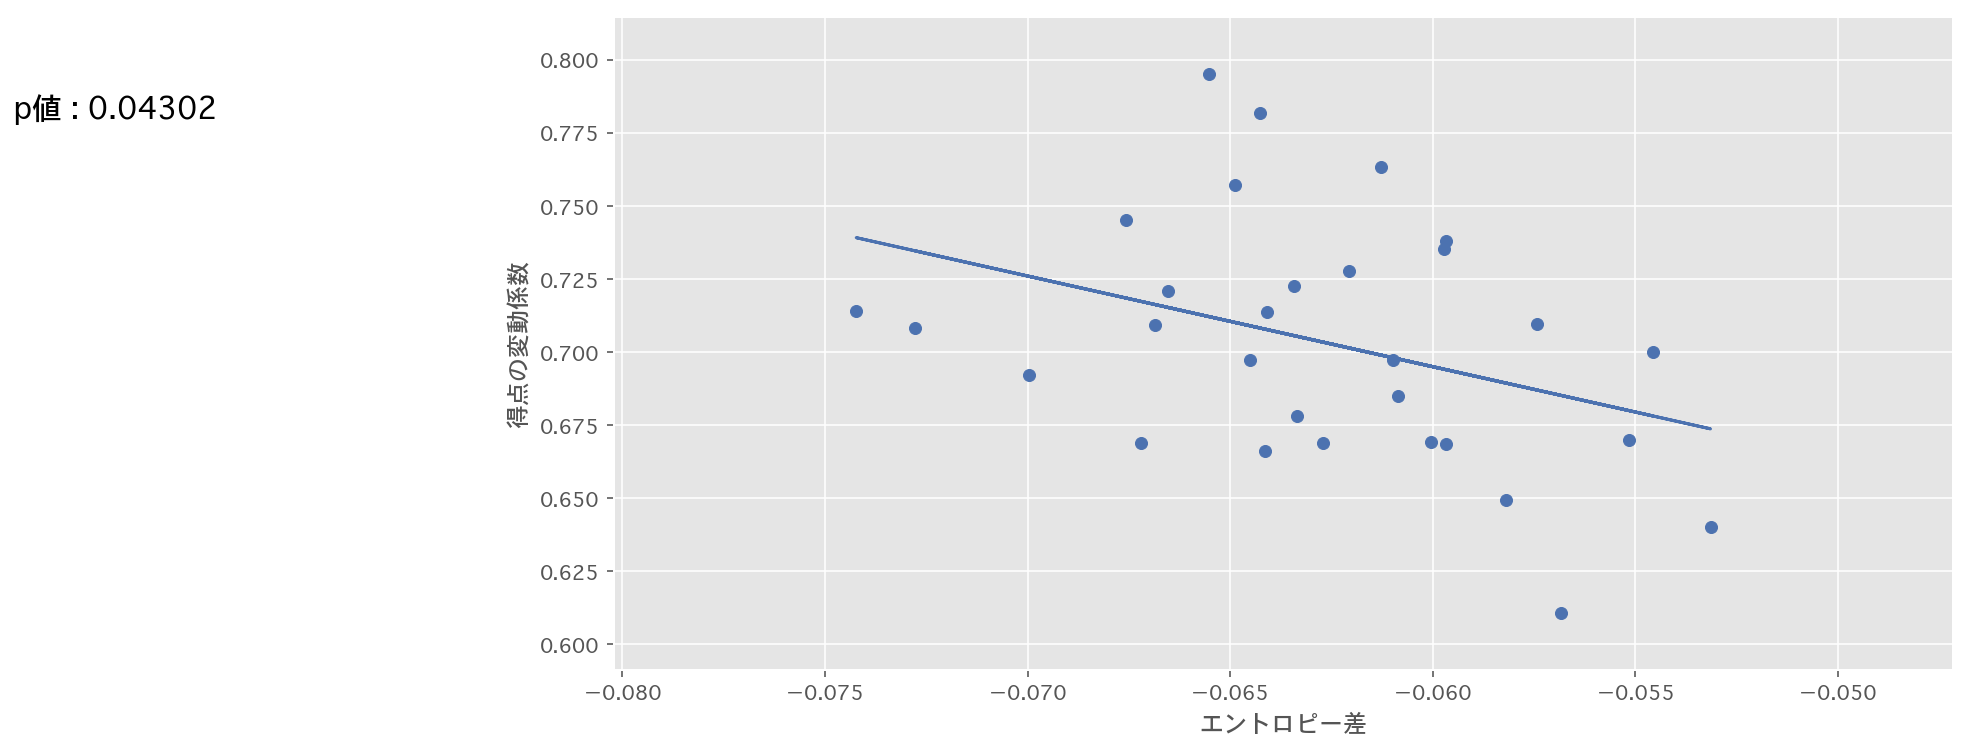

In [15]:
import statsmodels.api as sm

plt.figure(figsize=(12, 6))

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.xlabel("エントロピー差")
plt.ylabel("得点の変動係数")
plt.text(x=-0.095, y=0.78, s="p値 : "+str(results.pvalues[1])[:7], fontsize=15)
plt.show()

# 5回以降の4点差いないの状況、流れの良し悪しは見てない

In [16]:
diffs = []
stds = []
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[4:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = df_with_score[df_with_score.点差<=2][[0, 1, 2]].values.tolist()
    #improved_lst = [elem for elem in df_with_score[df_with_score.点差<=2][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team).describe()[column]["std"] / make_score_df_mlb(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)


マーリンズ -0.18148912351288082 0.745161351662
ブルージェイズ -0.17440595206819776 0.666022782951
Wソックス -0.15264000497522368 0.720786613389
ロイヤルズ -0.1606311750426861 0.757228903468
ジャイアンツ -0.14804126208367485 0.737955073316
ブレーブス -0.17039873820931373 0.70938418131
メッツ -0.15438847288347057 0.735159694044
マリナーズ -0.15580084149438456 0.668948069586
カブス -0.15640912868209034 0.763224672511
カージナルス -0.16277924951667355 0.668960338682
レンジャーズ -0.18710013282407578 0.714067340083
アスレチックス -0.16085967507138 0.640292515595
ロッキーズ -0.1643992007096462 0.6973869369
フィリーズ -0.15990673380873677 0.72758841746
ブリュワーズ -0.14277973650412834 0.670083659328
ヤンキース -0.15359546361950516 0.61072599013
レッズ -0.18845659726276676 0.678095136226
レイズ -0.16234296614388066 0.70014369491
パイレーツ -0.1812706223042193 0.713864249192
ドジャース -0.15537586198392406 0.697131500955
オリオールズ -0.14446421693626643 0.781906801829
ツインズ -0.15233432039840533 0.649470212774
Dバックス -0.16851951425435052 0.708102395369
インディアンス -0.14642696185674886 0.709479335467
パド

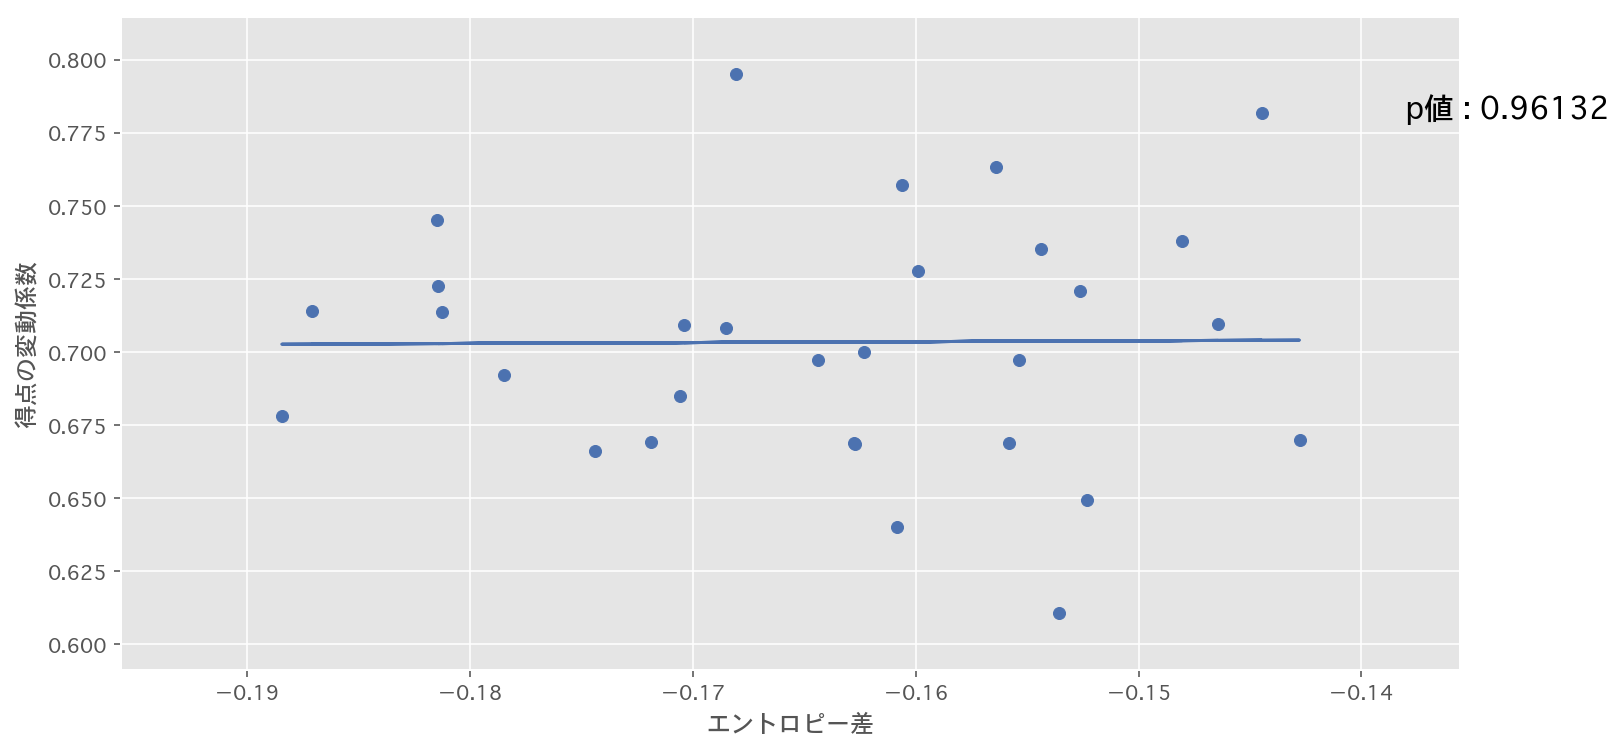

In [17]:
    
import statsmodels.api as sm

plt.figure(figsize=(12, 6))

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.xlabel("エントロピー差")
plt.ylabel("得点の変動係数")
plt.text(x=-0.138, y=0.78, s="p値 : "+str(results.pvalues[1])[:7], fontsize=15)
plt.show()

# 

In [18]:
diffs = []
stds = []
"""
for team in teams_mlb:
    df = df_2017[df_2017.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[4:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = [elem for elem in df_with_score[df_with_score.点差<=4][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team, 2017).describe()[column]["std"] / make_score_df_mlb(team, 2017).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)
"""
for team in teams_mlb:
    df = df_2018[df_2018.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[4:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = [elem for elem in df_with_score[df_with_score.点差<=4][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1], "score")]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team, 2018).describe()[column]["std"] / make_score_df_mlb(team, 2018).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)

マーリンズ -0.0710166972130657 0.733353859821
ブルージェイズ -0.09615876203300289 0.678415649609
Wソックス -0.09431260699288346 0.693906187087
ロイヤルズ -0.08611181330059159 0.702884289545
ジャイアンツ -0.0665212284884169 0.733145630832
ブレーブス -0.08386127410937227 0.698804842567
メッツ -0.08285931120960521 0.802488858453
マリナーズ -0.0836288959856768 0.651219045998
カブス -0.08377176922356355 0.769607655658
カージナルス -0.08416441647258877 0.670715947561
レンジャーズ -0.10728016787596495 0.779277092863
アスレチックス -0.07455197521276524 0.670510497596
ロッキーズ -0.08291728400421938 0.6754229857
フィリーズ -0.07703552460478624 0.774675633336
ブリュワーズ -0.07241617604644013 0.700645228329
ヤンキース -0.09313404871804654 0.547909769625
レッズ -0.08468837376721927 0.699232763933
レイズ -0.07863859647832738 0.722119648926
パイレーツ -0.0824348749828352 0.694631315943
ドジャース -0.09102169781210279 0.752206340683
オリオールズ -0.0971155993731454 0.848146059485
ツインズ -0.08965284680491026 0.639182765683
Dバックス -0.09720410688717207 0.71856002575
インディアンス -0.08295815880558921 0.72646343468

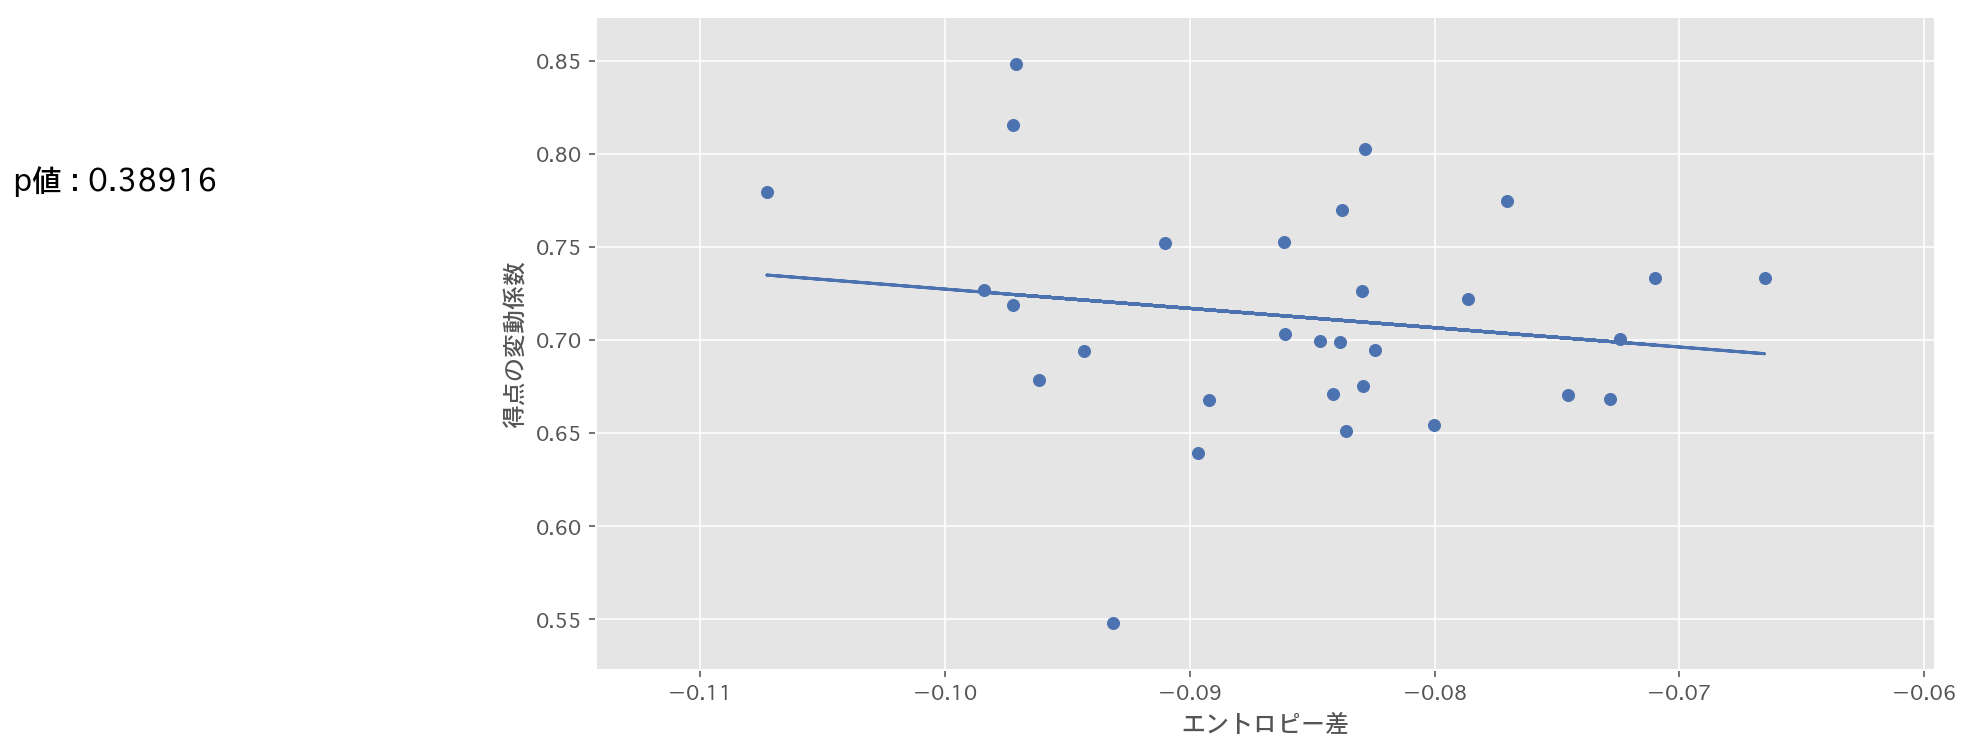

In [19]:
    
import statsmodels.api as sm

plt.figure(figsize=(12, 6))

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.xlabel("エントロピー差")
plt.ylabel("得点の変動係数")
plt.text(x=-0.138, y=0.78, s="p値 : "+str(results.pvalues[1])[:7], fontsize=15)
plt.show()

In [20]:
pd.DataFrame([diffs, stds, teams_mlb]).T.sort_values(0)

,0,1,2
10,-0.10728,0.779277,レンジャーズ
29,-0.0983862,0.726875,エンゼルス
26,-0.0972116,0.815253,ナショナルズ
22,-0.0972041,0.71856,Dバックス
20,-0.0971156,0.848146,オリオールズ
1,-0.0961588,0.678416,ブルージェイズ
2,-0.0943126,0.693906,Wソックス
15,-0.093134,0.54791,ヤンキース
19,-0.0910217,0.752206,ドジャース
21,-0.0896528,0.639183,ツインズ


In [21]:
%%latex

$$
    \text{エントロピー差} = H(S_{t+1}|S_{t}, S_{t-1}) - H(S_{t+1}|S_{t})
$$

<IPython.core.display.Latex object>

In [22]:
diffs = []
stds = []
for team in teams_mlb:
    df = df_2018[df_2018.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[4:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = [elem for elem in df_with_score[df_with_score.点差<=4][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1], "score")]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team, 2018).describe()[column]["std"] / make_score_df_mlb(team, 2018).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)

マーリンズ -0.0710166972130657 0.733353859821
ブルージェイズ -0.09615876203300289 0.678415649609
Wソックス -0.09431260699288346 0.693906187087
ロイヤルズ -0.08611181330059159 0.702884289545
ジャイアンツ -0.0665212284884169 0.733145630832
ブレーブス -0.08386127410937227 0.698804842567
メッツ -0.08285931120960521 0.802488858453
マリナーズ -0.0836288959856768 0.651219045998
カブス -0.08377176922356355 0.769607655658
カージナルス -0.08416441647258877 0.670715947561
レンジャーズ -0.10728016787596495 0.779277092863
アスレチックス -0.07455197521276524 0.670510497596
ロッキーズ -0.08291728400421938 0.6754229857
フィリーズ -0.07703552460478624 0.774675633336
ブリュワーズ -0.07241617604644013 0.700645228329
ヤンキース -0.09313404871804654 0.547909769625
レッズ -0.08468837376721927 0.699232763933
レイズ -0.07863859647832738 0.722119648926
パイレーツ -0.0824348749828352 0.694631315943
ドジャース -0.09102169781210279 0.752206340683
オリオールズ -0.0971155993731454 0.848146059485
ツインズ -0.08965284680491026 0.639182765683
Dバックス -0.09720410688717207 0.71856002575
インディアンス -0.08295815880558921 0.72646343468

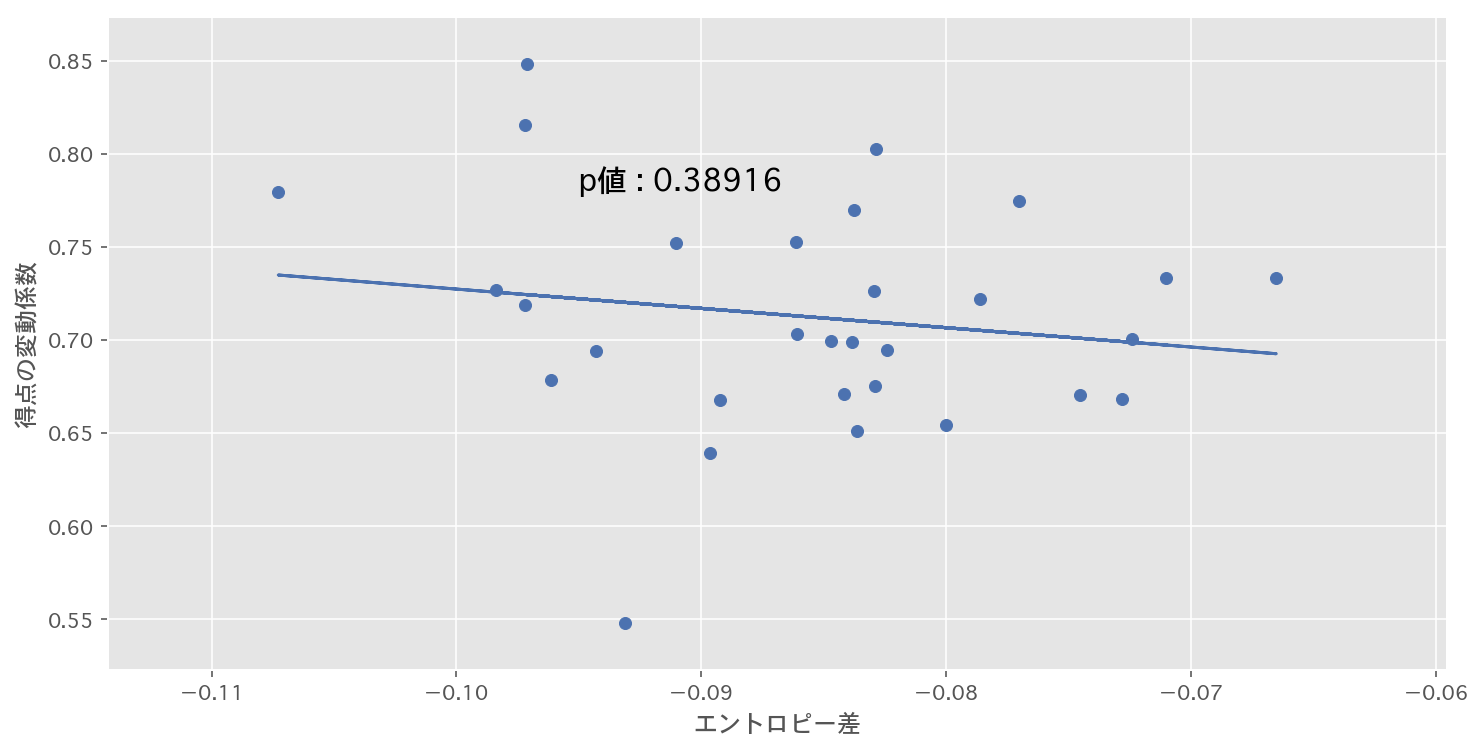

In [23]:
import statsmodels.api as sm

plt.figure(figsize=(12, 6))

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.xlabel("エントロピー差")
plt.ylabel("得点の変動係数")
plt.text(x=-0.095, y=0.78, s="p値 : "+str(results.pvalues[1])[:7], fontsize=15)
plt.show()

In [24]:
diffs = []
stds = []
for team in teams_mlb:
    df = df_2017[df_2017.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[4:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = [elem for elem in df_with_score[df_with_score.点差<=4][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1], "score")]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team, 2017).describe()[column]["std"] / make_score_df_mlb(team, 2017).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)

マーリンズ -0.10881772881061202 0.724665891875
ブルージェイズ -0.0861236368508771 0.654990133375
Wソックス -0.07694303638006206 0.745736264364
ロイヤルズ -0.08792450611997893 0.802390607321
ジャイアンツ -0.10144316030084832 0.738953741163
ブレーブス -0.10276020891303528 0.723353081757
メッツ -0.08716226750368294 0.664175872054
マリナーズ -0.08807315516261971 0.68006443293
カブス -0.09286085966829427 0.757046499267
カージナルス -0.1073782165015702 0.669382342759
レンジャーズ -0.1096621331781873 0.652676190958
アスレチックス -0.08210765902127592 0.59762417536
ロッキーズ -0.08613459501520682 0.719744048364
フィリーズ -0.08648306270144435 0.681688111587
ブリュワーズ -0.07981113239633864 0.626907756314
ヤンキース -0.0882008541050654 0.672266652063
レッズ -0.09564874898696685 0.656421091521
レイズ -0.07826105258690896 0.674622050404
パイレーツ -0.09200199796186981 0.736718942171
ドジャース -0.0854527308773303 0.634707044734
オリオールズ -0.07679828585739035 0.714069069308
ツインズ -0.07686180384069807 0.660517905311
Dバックス -0.10796299353465733 0.689247452325
インディアンス -0.07568666738622598 0.6934526383

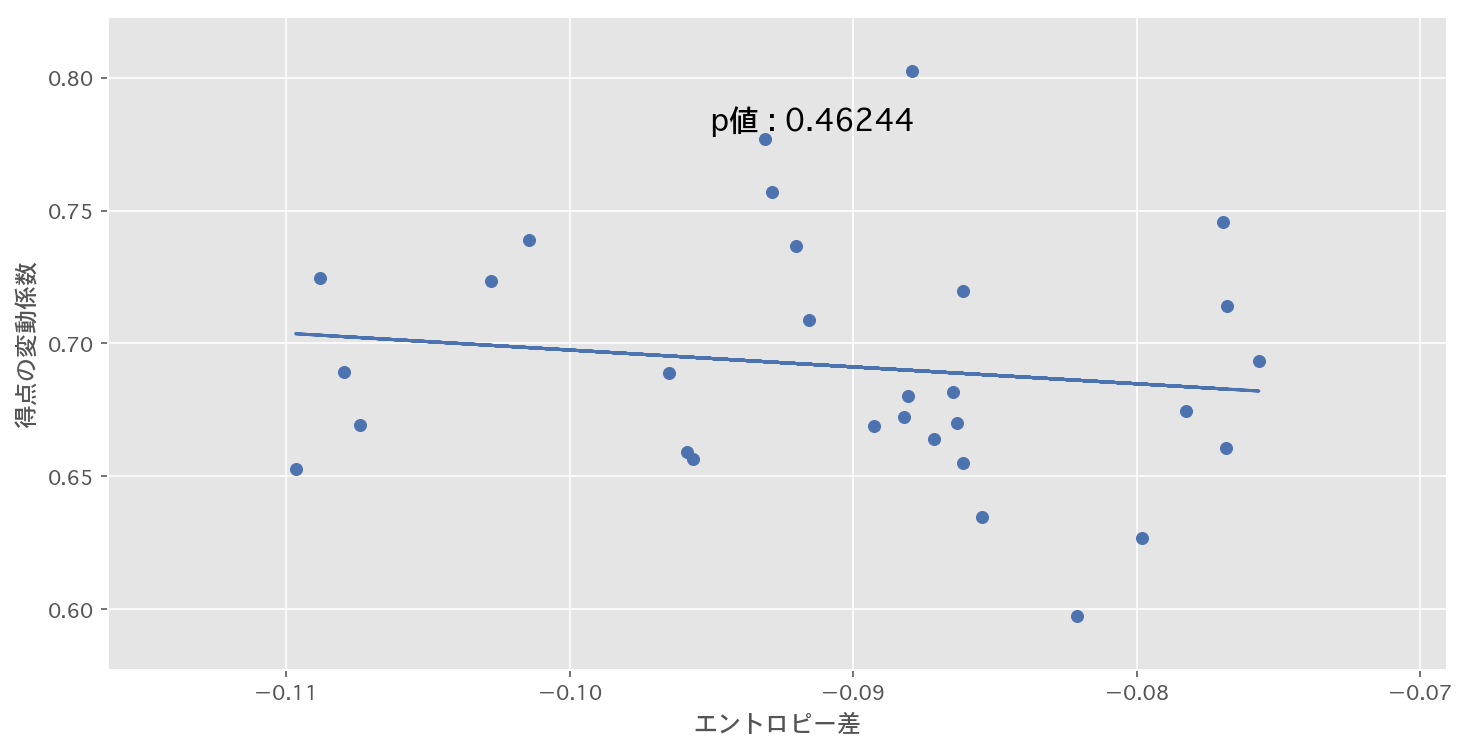

In [25]:
import statsmodels.api as sm

plt.figure(figsize=(12, 6))

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.xlabel("エントロピー差")
plt.ylabel("得点の変動係数")
plt.text(x=-0.095, y=0.78, s="p値 : "+str(results.pvalues[1])[:7], fontsize=15)
plt.show()